This is another notebook for preprocessing but the difference here is that we mapped emojis and emoticons into Arabic text 


In [ ]:
#importing libaraires

# Add environment Packages paths to conda
import os, sys, warnings
import pandas as pd
import numpy as np
warnings.simplefilter("ignore")

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
import regex
import emoji
# Corpora is a group presenting multiple collections of text documents. A single collection is called corpus.
from nltk.corpus import stopwords # Stopwords
import arabicstopwords.arabicstopwords as stp #more range of arabic stop words
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from tashaphyne.stemming import ArabicLightStemmer

from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
#from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC
# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

In [ ]:
#!pip install nltk
#!pip install emoji
#!pip install Arabic-Stopwords
#pip install PyArabic
#pip install Tashaphyne
#pip install translate
#pip install transformers

In [ ]:
df=pd.read_excel('NileUniversity_Emotional.xlsx')
df.head()

,ID,text,label
0,1,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,2,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,3,كتنا نيله ف حظنا الهباب xD,sadness
3,4,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,5,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none


In [ ]:
#deop unnecessary columns
df.drop('ID', axis=1,inplace=True)

## Assessing

In [ ]:
#print the shape of the data set
df.shape

(10065, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10065 entries, 0 to 10064
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10064 non-null  object
 1   label   10065 non-null  object
dtypes: object(2)
memory usage: 157.4+ KB


In [ ]:
#check if the data is balanced or not
df.label.value_counts()

none        1550
anger       1444
joy         1281
sadness     1256
love        1220
fear        1207
sympathy    1062
surprise    1045
Name: label, dtype: int64

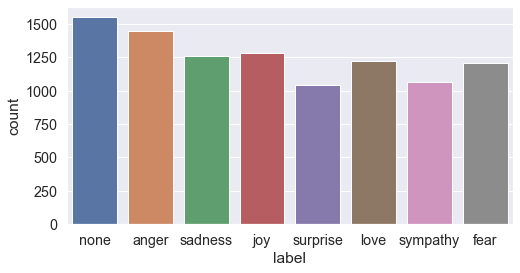

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df);

The differences between the labels is not large so, we can say that the data is balanced

In [ ]:
#print the number of null values in each column
df.isnull().sum()

text     1
label    0
dtype: int64

In [ ]:
#to get the index of the null value
df[df['text'].isnull() == True]

,text,label
8619,NaN,love


This label doesn't mean anything because the original text is missing so, we will remove it

In [ ]:
#removing null value
df.drop(8619, axis=0, inplace = True)

#resetting the index of the data
df.reset_index(drop=True, inplace = True)

In [ ]:
#print the number of duplicated values 
df.duplicated().sum()

36

In [ ]:
#print the rows which are duplicated
df[df['text'].duplicated() == True]

,text,label
1236,الشخص الذي يجعلُك من اساسيات يومه، يستحقُ ان ت...,love
1449,: اليوم العالمي للشباب الامم المتحده تمنح جائ...,love
1487,اللهم يا من قلت ادعوني استجب لكم ، انصر اخوانن...,sympathy
2115,: اللهّم خفف عن جدتي كُل ذره وجع ترهقها وانزل ...,sympathy
2826,: لعب من اجل النصر! اعطي من اجل النصر! ضحّي من...,love
2916,: لا تستطيع ان تستقيم بحياه مريحه نفسياً وانت ...,sympathy
3699,حماده طلعت اللي رفع العلم السعودي في الاوليمبي...,anger
3944,يا اهل مصر قلوبنا ودعائنا معكم نازلين 11 11 عشان,sympathy
4319,alqarnee: يا حي ياقيوم يا ذا الجلال والاكرام ف...,sympathy
4398,في الاوليمبياد مع نيجيريا,none


In [ ]:
df[df['text'] == df.iloc[1236]['text']]

,text,label
790,الشخص الذي يجعلُك من اساسيات يومه، يستحقُ ان ت...,love
1236,الشخص الذي يجعلُك من اساسيات يومه، يستحقُ ان ت...,love


In [ ]:
#removing duplicated values
index = df[df['text'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)

In [ ]:
#are there any stop words in the data?
arabic_stopwords = stopwords.words("arabic")
len(arabic_stopwords)

754

Note that There are different libraries provide a different numbers of arabic stop words like "nltk" and "arabicstopwords" now we will use nltk's arabic stopwords and we will see the results and if needed we can use "arabicstopwords" library which provide the stopwords and it's conjugations

In [ ]:
df['stop_words'] = df['text'].apply(lambda x: len(set(x.split()) & set(arabic_stopwords)))
df.stop_words.value_counts()

1     2843
2     2328
0     1907
3     1532
4      843
5      371
6      134
7       43
8       16
9        2
10       1
Name: stop_words, dtype: int64

<AxesSubplot:ylabel='Frequency'>

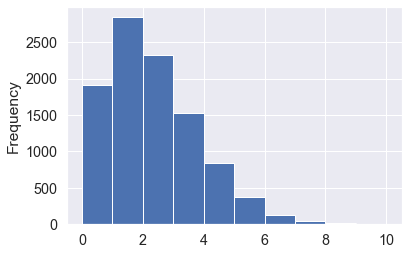

In [ ]:
df['stop_words'].plot(kind= 'hist')

it seems that the data contains alot of stop words and it should be removed

In [ ]:
#to count the number of emojis in the dataset
def emoji_counter(sentence):
    return emoji.emoji_count(sentence)

df['emoji_count'] = df['text'].apply(lambda x: emoji_counter(x))
df.emoji_count.value_counts()[:10]

0    8114
1    1031
2     527
3     173
4      85
5      39
6      18
7      14
9       7
8       6
Name: emoji_count, dtype: int64

most of the records doesn't contain emojies but there are about 1910 emoji that we should take care during preprocessing

**extract the emojis from every text**

In [ ]:
emojis_data = df[df['emoji_count'] > 0]

In [ ]:
def extract_emoji(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [ ]:
emojis_data['emoji'] = emojis_data['text'].apply(lambda x: extract_emoji(x))
emojis_data['emoji'] = emojis_data['emoji'].apply(lambda x: ' '.join([word for word in x ]))

In [ ]:
emojis_data

,text,label,stop_words,emoji_count,emoji
12,يا ويل قلبي منه ي كثر ما اغليه ويا كثر ماله ف...,love,6,1,❤
18,المفروض يلغوها من الاوليمبياد وندخل الاسكواش م...,none,1,1,😂
19,25jan اعوذ بالله مايسوي هذا الرز اللي تحكوا ...,sympathy,2,1,💔
24,بعثه مصر في الاوليمبياد رايحه تتفرج زيها زينا 😂😂,none,1,2,😂 😂
27,: كل التوفيق للجهاز الاداري بقياده عبدالعزيز ا...,sympathy,1,3,💚 💚 💚
...,...,...,...,...,...
10048,تدري وش اللي مَ يخليني انساك ؟اني لا جيِت احب ...,love,1,1,💙
10056,للامانه كنت متعاطفه مع هيلاري كثير لانها حرمه ...,sympathy,1,1,😁
10057,كنت خايفه من هاد اليوم 💔💔💔 فاقولنا يا جدك الج...,fear,2,3,💔 💔 💔
10060,Mohamed5: اييييه دااا 😲😲 اوزيييل❤,surprise,0,3,😲 😲 ❤


In [ ]:
#find most repeated emojis
pd.Series(' '.join(emojis_data['emoji']).split()).value_counts()[:10]

😂     730
💔     282
❤     159
❤️    151
😍     132
😭     122
♥      86
😢      86
✋      83
😔      74
dtype: int64

Face With Tears of Joy is the most repeated emoji

In [ ]:
df.text.iloc[99]

'والقلبُ متلهّفٌ؛ لنعيمٍ سرمدي❤️'

After Exploring some records we found Diacritics in the dataset and we should put this in our considerations

In [ ]:
df

,text,label,stop_words,emoji_count
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none,1,0
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,2,0
2,كتنا نيله ف حظنا الهباب xD,sadness,1,0
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,2,0
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none,1,0
...,...,...,...,...
10059,2222: يلا يا جماعه حفله عمرو دياب خلصت نريح شو...,sadness,1,0
10060,Mohamed5: اييييه دااا 😲😲 اوزيييل❤,surprise,0,3
10061,عملتلها ريتويت بمناسبه ساره بتاعه الاوليمبياد 😃,none,0,1
10062,وعليك قبلنا يانجم النجوم ياعندليب الحب والاحساس,joy,0,0


### Assessing Results

- The data contains null values
- The data contains duplicated values
- The data is balanced and contains 8 classes
- About 20% of the data contains emojis
- More than 85% of the text in each records contains stopwords
- the data contains Diacritics 
- The data contains Punctuations, Disapprobation words and hashtags and other things that we should take care during cleaning and preprocessing
- Face With Tears of Joy is the most repeated emoji

## Cleaning

### Constants and important variables

In [ ]:
emojis = {
    "🙂":"يبتسم",
    "😂":"يضحك",
    "💔":"قلب حزين",
    "🙂":"يبتسم",
    "❤️":"حب",
    "❤":"حب",
    "😍":"حب",
    "😭":"يبكي",
    "😢":"حزن",
    "😔":"حزن",
    "♥":"حب",
    "💜":"حب",
    "😅":"يضحك",
    "🙁":"حزين",
    "💕":"حب",
    "💙":"حب",
    "😞":"حزين",
    "😊":"سعادة",
    "👏":"يصفق",
    "👌":"احسنت",
    "😴":"ينام",
    "😀":"يضحك",
    "😌":"حزين",
    "🌹":"وردة",
    "🙈":"حب",
    "😄":"يضحك",
    "😐":"محايد",
    "✌":"منتصر",
    "✨":"نجمه",
    "🤔":"تفكير",
    "😏":"يستهزء",
    "😒":"يستهزء",
    "🙄":"ملل",
    "😕":"عصبية",
    "😃":"يضحك",
    "🌸":"وردة",
    "😓":"حزن",
    "💞":"حب",
    "💗":"حب",
    "😑":"منزعج",
    "💭":"تفكير",
    "😎":"ثقة",
    "💛":"حب",
    "😩":"حزين",
    "💪":"عضلات",
    "👍":"موافق",
    "🙏🏻":"رجاء طلب",
    "😳":"مصدوم",
    "👏🏼":"تصفيق",
    "🎶":"موسيقي",
    "🌚":"صمت",
    "💚":"حب",
    "🙏":"رجاء طلب",
    "💘":"حب",
    "🍃":"سلام",
    "☺":"يضحك",
    "🐸":"ضفدع",
    "😶":"مصدوم",
    "✌️":"مرح",
    "✋🏻":"توقف",
    "😉":"غمزة",
    "🌷":"حب",
    "🙃":"مبتسم",
    "😫":"حزين",
    "😨":"مصدوم",
    "🎼 ":"موسيقي",
    "🍁":"مرح",
    "🍂":"مرح",
    "💟":"حب",
    "😪":"حزن",
    "😆":"يضحك",
    "😣":"استياء",
    "☺️":"حب",
    "😱":"كارثة",
    "😁":"يضحك",
    "😖":"استياء",
    "🏃🏼":"يجري",
    "😡":"غضب",
    "🚶":"يسير",
    "🤕":"مرض",
    "‼️":"تعجب",
    "🕊":"طائر",
    "👌🏻":"احسنت",
    "❣":"حب",
    "🙊":"مصدوم",
    "💃":"سعادة مرح",
    "💃🏼":"سعادة مرح",
    "😜":"مرح",
    "👊":"ضربة",
    "😟":"استياء",
    "💖":"حب",
    "😥":"حزن",
    "🎻":"موسيقي",
    "✒":"يكتب",
    "🚶🏻":"يسير",
    "💎":"الماظ",
    "😷":"وباء مرض",
    "☝":"واحد",
    "🚬":"تدخين",
    "💐" : "ورد",
    "🌞" : "شمس",
    "👆" : "الاول",
    "⚠️" :"تحذير",
    "🤗" : "احتواء",
    "✖️": "غلط",
    "📍"  : "مكان",
    "👸" : "ملكه",
    "👑" : "تاج",
    "✔️" : "صح",
    "💌": "قلب",
    "😲" : "مندهش",
    "💦": "ماء",
    "🚫" : "خطا",
    "👏🏻" : "برافو",
    "🏊" :"يسبح",
    "👍🏻": "تمام",
    "⭕️" :"دائره كبيره",
    "🎷" : "ساكسفون",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝":"مبتسم",
    "➿"  : "عقده مزدوجه",
    "💪🏼" : "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧" : "قلق و صدمة",
    "🗨": "رسالة",   
    "❗️" :"تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯" :"اخوات",
    "©" :  "رمز",
    "👵🏽" :"سيده عجوزه",
    "🐣": "كتكوت",  
    "🙌": "تشجيع",
    "🙇": "شخص ينحني",
    "👐🏽":"ايدي مفتوحه",    
    "👌🏽": "بالظبط",
    "⁉️" : "استنكار",
    "⚽️": "كوره",
    "🕶" :"حب",
    "🎈" :"بالون",    
    "🎀":    "ورده",
    "💵":  "فلوس",   
    "😋":  "جائع",
    "😛":  "يغيظ",
    "😠":  "غاضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",
    "👣":  "اثر قدمين",
    "❌":"رفض",
    "🍟":"طعام",
    "👬":"صداقة",
    "🐰":"ارنب",
    "☂":"مطر",
    "⚜":"مملكة فرنسا",
    "🐑":"خروف",
    "🗣":"صوت مرتفع",
    "👌🏼":"احسنت",
    "☘":"مرح",
    "😮":"صدمة",
    "😦":"قلق",
    "⭕":"الحق",
    "✏️":"قلم",
    "ℹ":"معلومات",
    "🙍🏻":"رفض",
    "⚪️":"نضارة نقاء",
    "🐤":"حزن",
    "💫":"مرح",
    "💝":"حب",
    "🍔":"طعام",
    "❤︎":"حب",
    "✈️":"سفر",
    "🏃🏻‍♀️":"يسير",
    "🍳":"ذكر",
    "🎤":"مايك غناء",
    "🎾":"كره",
    "🐔":"دجاجة",
    "🙋":"سؤال",
    "📮":"بحر",
    "💉":"دواء",
    "🙏🏼":"رجاء طلب",
    "💂🏿 ":"حارس",
    "🎬":"سينما",
    "♦️":"مرح",
    "💡":"قكرة",
    "‼":"تعجب",
    "👼":"طفل",
    "🔑":"مفتاح",
    "♥️":"حب",
    "🕋":"كعبة",
    "🐓":"دجاجة",
    "💩":"معترض",
    "👽":"فضائي",
    "☔️":"مطر",
    "🍷":"عصير",
    "🌟":"نجمة",
    "☁️":"سحب",
    "👃":"معترض",
    "🌺":"مرح",
    "🔪":"سكينة",
    "♨":"سخونية",
    "👊🏼":"ضرب",
    "✏":"قلم",
    "🚶🏾‍♀️":"يسير",
    "👊":"ضربة",
    "◾️":"وقف",
    "😚":"حب",
    "🔸":"مرح",
    "👎🏻":"لا يعجبني",
    "👊🏽":"ضربة",
    "😙":"حب",
    "🎥":"تصوير",
    "👉":"جذب انتباه",
    "👏🏽":"يصفق",
    "💪🏻":"عضلات",
    "🏴":"اسود",
    "🔥":"حريق",  
    "😬":"عدم الراحة",   
    "👊🏿":"يضرب",    
    "🌿":"ورقه شجره",     
    "✋🏼":"كف ايد",    
    "👐":"ايدي مفتوحه",      
    "☠️":"وجه مرعب",     
    "🎉":"يهنئ",      
    "🔕" :"صامت",
    "😿":"وجه حزين",      
    "☹️":"وجه يائس",     
    "😘" :"حب",     
    "😰" :"خوف و حزن",
    "🌼":"ورده",      
    "💋":  "بوسه",
    "👇":"لاسفل",     
    "❣️":"حب",     
    "🎧":"سماعات",
    "📝":"يكتب",      
    "😇":"دايخ",      
    "😈":"رعب",      
    "🏃":"يجري",      
    "✌🏻":"علامه النصر",    
    "🔫":"يضرب",      
    "❗️":"تعجب",
    "👎":"غير موافق",      
    "🔐":"قفل",      
    "👈":"لليمين",
    "™":"رمز",    
    "🚶🏽":"يتمشي",    
    "😯":"متفاجأ",  
    "✊":"يد مغلقه",    
    "😻":"اعجاب",    
    "🙉" :"قرد",    
    "👧":"طفله صغيره",     
    "🔴":"دائره حمراء",      
    "💪🏽":"قوه",     
    "💤":"ينام",     
    "👀":"ينظر",     
    "✍🏻":"يكتب",  
    "❄️":"تلج",
    "💀":"رعب",   
    "😤":"وجه عابس",      
    "🖋":"قلم",      
    "🎩":"كاب",      
    "☕️":"قهوه",     
    "😹":"ضحك",     
    "💓":"حب",      
    "☄️ ":"نار",     
    "👻":"رعب",
    }

emoticons_to_emoji = {
    ":)" : "🙂",
    ":(" : "🙁",
    "xD" : "😆",
    ":=(": "😭",
    ":'(": "😢",
    ":'‑(": "😢",
    "XD" : "😂",
    ":D" : "🙂",
    "♬" : "موسيقي",
    "♡" : "❤",
    "☻"  : "🙂",
    }

### Functions

In [ ]:
def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in arabic_stopwords]
    return " ".join(Text)

def ISRI_Stemmer(text):
    #making an object
    stemmer = ISRIStemmer()
    
    #stemming each word
    text = stemmer.stem(text)
    text = stemmer.pre32(text)
    text = stemmer.suf32(text)
    
    return text

def Snowball_stemmer(text):
    text = text.split()
    #making an object
    stemmer = SnowballStemmer("arabic")
    
    #stemming each word
    text=[stemmer.stem(y) for y in text]
    
    return " " .join(text)

def Arabic_Light_Stemmer(text):
    #making an object
    Arabic_Stemmer = ArabicLightStemmer()
    
    #stemming each word
    text=[Arabic_Stemmer.light_stem(y) for y in text.split()]
    
    return " " .join(text)

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    
    #remove repetetions
    text = re.sub("[إأٱآا]", "ا", text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('ييي', 'ي')
    text = text.replace('اا', 'ا')

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # Remove longation
    text = re.sub(r'(.)\1+', r"\1\1", text) 
    
    #Strip vowels from a text, include Shadda.
    text = araby.strip_tashkeel(text)
    
    #Strip diacritics from a text, include harakats and small lettres The striped marks are
    text = araby.strip_diacritics(text)
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_non_arabic(text):
    text = re.sub('[A-Za-z]+',' ',text)
    return text

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emoji(string):
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string).strip()

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text).strip()



def remove_extra_Space(text):
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    return  " ".join(text.split())

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
            
def replace_emoticon_with_emojis(text):
    for i in range (len(text)):
        message = text.iloc[i]
        seperarate_word = message.split(' ')
        cleaned_data.text.iloc[i] = ""

        for word in seperarate_word:
            text.iloc[i] += emoticons_to_emoji.get(word, word) + " "

def replace_emojis_with_text(text):
    for i in range (len(text)):
            message = text.iloc[i]
            seperarate_word = regex.findall(r'\X', message)
            text.iloc[i] = ""

            for word in seperarate_word:
                if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
                        text.iloc[i] += " " + emojis.get(word, word) + " "
                else:
                        text.iloc[i] +=  emojis.get(word, word) + ""
            
def space_between_emojis(s): 
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)


In [ ]:
cleaned_data = pd.read_excel('NileUniversity_Emotional.xlsx')

In [ ]:
cleaned_data.head()

,ID,text,label
0,1,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,2,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,3,كتنا نيله ف حظنا الهباب xD,sadness
3,4,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,5,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none


**drop unnecessary columns**

In [ ]:
cleaned_data.drop('ID', axis=1,inplace=True)

**removing null values**

In [ ]:
cleaned_data.drop(8619, axis=0, inplace = True)

In [ ]:
#Before
cleaned_data.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
#Ater
cleaned_data.isnull().sum()

text     0
label    0
dtype: int64

**removing duplicated values**

In [ ]:
num_of_duplications = cleaned_data.duplicated().sum()
index = cleaned_data[cleaned_data['text'].duplicated() == True].index
cleaned_data.drop(index, axis = 0, inplace = True)

#resetting the index of the data
cleaned_data.reset_index(drop=True, inplace = True)

In [ ]:
#Before
num_of_duplications

36

In [ ]:
#Ater
cleaned_data.duplicated().sum()

0

**Replace emoticons with emojis**

In [ ]:
#cleaned_data.text=cleaned_data.text.apply(lambda text : remove_emoji(text))
replace_emoticon_with_emojis(cleaned_data.text)

In [ ]:
#Before
df.iloc[2].text

'كتنا نيله ف حظنا الهباب xD'

In [ ]:
#After
cleaned_data.iloc[2].text

'كتنا نيله ف حظنا الهباب 😆 '

In [ ]:
#we will save this data mapping the emojis into words
cleaned_data.to_csv('cleaned_data_with_emojis.csv', index = False, encoding='utf-8-sig')

**Replace each emoji with a text**

In [ ]:
replace_emojis_with_text(cleaned_data.text)

In [ ]:
cleaned_data.iloc[2].text

'كتنا نيله ف حظنا الهباب  يضحك  '

**removing arabic stopwords**

In [ ]:
cleaned_data.text=cleaned_data.text.apply(lambda text : remove_stop_words(text))

In [ ]:
#Before
df.text[1]

'عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني لسه اقل من 7 % و نفلس و بهايم لسه يتابعوا الاوليمبياد'

In [ ]:
#After
cleaned_data.text[1]

'عجز الموازنه وصل ل93.7 % الناتج المحلي يعني لسه اقل 7 % نفلس بهايم لسه يتابعوا الاوليمبياد'

**Removal of non-Arabic words**

In [ ]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_non_arabic(text))

In [ ]:
#Before
df.text.iloc[10016]

'Mohamed5: اييييه دااا 😲😲 اوزيييل❤'

In [ ]:
#After
cleaned_data.iloc[10016].text

' 5: اييييه دااا مندهش مندهش اوزيييل حب'

**removing Diacritics**

In [ ]:
cleaned_data.text=cleaned_data.text.apply(lambda text : normalizeArabic(text))

In [ ]:
df.text.iloc[99]

'والقلبُ متلهّفٌ؛ لنعيمٍ سرمدي❤️'

In [ ]:
cleaned_data.text.iloc[99]

'والقلب متلهف؛ لنعيم سرمدي حب'

**Removal of numbers**

In [ ]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_numbers(text))

In [ ]:
#Before
df.text.iloc[10015]

'2222: يلا يا جماعه حفله عمرو دياب خلصت نريح شويه ونبدا نكتئب ونعشم نفسنا اننا هنروح الحفله التانيه وبعدين نقطع شرايينا يلا.'

In [ ]:
cleaned_data.iloc[10015].text

': يلا جماعه حفله عمرو دياب خلصت نريح شويه ونبدا نكتءب ونعشم نفسنا اننا هنروح الحفله التانيه وبعدين نقطع شراينا يلا.'

**Removing Hastags**

In [ ]:
for i in range(len(cleaned_data)):
    index = cleaned_data.text.iloc[i].find("#")
    if index != -1:
        print(index)

it seems that the data doesn't contains hastgas

**Removal of Links**

In [ ]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_urls(text))

**Removing Punctuations**

In [ ]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_punctuations(text))

In [ ]:
#Before
df.text.iloc[0]

'الاوليمبياد الجايه هكون لسه ف الكليه ..'

In [ ]:
#After
cleaned_data.text.iloc[0]

'الاوليمبياد الجايه هكون لسه الكليه'

**Reducing words to their roots**

In [ ]:
cleaned_data.text=cleaned_data.text.apply(lambda text : ISRI_Stemmer(text))

In [ ]:
cleaned_data.duplicated().sum()

109

Note that: duplicated value was found when we remove diacritics and non arabic words and punctuations and this because some rows in the dataset only contains stopwords or it contains one or two words and other reasons so, we have to remove the duplicated values again

In [ ]:
index = cleaned_data[cleaned_data['text'].duplicated() == True].index
cleaned_data.drop(index, axis = 0, inplace = True)

#resetting the index of the data
cleaned_data.reset_index(drop=True, inplace = True)

In [ ]:
cleaned_data.duplicated().sum()

0

After removing the duplicated values we will remove every row which contains only one or two words berfore preprocessing

In [ ]:
#this function will convert the text which contains one or two words into null value
remove_small_sentences(cleaned_data)

In [ ]:
cleaned_data.isnull().sum()

text     231
label      0
dtype: int64

In [ ]:
cleaned_data.dropna(inplace = True)

In [ ]:
cleaned_data.to_csv('cleaned_data_IRIS.csv', index = False, encoding='utf-8-sig')

## Modeling

In [ ]:
X = cleaned_data.text.values
y = cleaned_data.label.values

In [ ]:
print(X[:5])

['الاوليمبياد جايه هك سه كليه'
 'عجز موازنه صل ل ناتج محل عني سه قل فلس هايم سه تابع الاوليمبياد'
 'تنا يل حظ هباب ضح' 'جميع ريد حقيق هداف ونس تالق حراس مرم'
 'الاوليمبياد ظام مختلف مواعيد مونديال مكانتش مقرف حاج انت معقول']


In [ ]:
print(y[:5])

['none' 'anger' 'sadness' 'joy' 'none']


**Creating a pipline using tf-idf for words embedding and different models.**

In [ ]:
def train_model(model, data, targets):
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    text_clf.fit(data, targets)
    return text_clf

In [ ]:
def get_F1(trained_model,X,y):
    predicted=trained_model.predict(X)
    f1=f1_score(y,predicted, average=None)
    return f1

**Splitting the dataset into the Training set and Test set**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1,shuffle=True, random_state=42)

### Logistic Regression

**Training the Logistic Regression model on the Training set**

In [ ]:
log_reg = train_model(LogisticRegression(random_state = 0), X_train, y_train)

**Predicting new data**

In [ ]:
y_pred=log_reg.predict(['سعيد'])
y_pred

array(['joy'], dtype=object)

In [ ]:
y_pred=log_reg.predict(['حزن'])
y_pred

array(['sadness'], dtype=object)

In [ ]:
y_pred=log_reg.predict(['مستغرب'])
y_pred

array(['surprise'], dtype=object)

**Predicting the Test set results**

In [ ]:
y_pred=log_reg.predict(X_test)

**Measuring the performance**

In [ ]:
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

Accuracy:  0.6694214876033058 



In [ ]:
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df.label.unique(), columns=['F1 score'])

,F1 score
none,0.628205
anger,0.947867
sadness,0.520930
joy,0.712551
surprise,0.693410
love,0.504587
sympathy,0.467532
fear,0.817391


In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.54      0.75      0.63       131
        fear       0.96      0.93      0.95       107
         joy       0.61      0.46      0.52       123
        love       0.72      0.71      0.71       124
        none       0.58      0.86      0.69       140
     sadness       0.58      0.45      0.50       123
    surprise       0.67      0.36      0.47       100
    sympathy       0.85      0.78      0.82       120

    accuracy                           0.67       968
   macro avg       0.69      0.66      0.66       968
weighted avg       0.68      0.67      0.66       968



### Decision Tree

**Training the Decision Tree model on the Training set**

In [ ]:
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

**Predicting the Test set results**

In [ ]:
y_pred=DT.predict(X_test)

**Measuring the performance**

In [ ]:
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

Accuracy:  0.5547520661157025 



In [ ]:
f1_Score = get_F1(DT, X_test ,y_test)
pd.DataFrame(f1_Score, index=df.label.unique(), columns=['F1 score'])

,F1 score
none,0.475472
anger,0.921659
sadness,0.363636
joy,0.567686
surprise,0.622951
love,0.348936
sympathy,0.410526
fear,0.727273


In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.47      0.48      0.48       131
        fear       0.91      0.93      0.92       107
         joy       0.35      0.37      0.36       123
        love       0.62      0.52      0.57       124
        none       0.58      0.68      0.62       140
     sadness       0.37      0.33      0.35       123
    surprise       0.43      0.39      0.41       100
    sympathy       0.72      0.73      0.73       120

    accuracy                           0.55       968
   macro avg       0.56      0.56      0.55       968
weighted avg       0.55      0.55      0.55       968



### Support Vector Machine

**Training the Support Vector Machine model on the Training set**

In [ ]:
SVM = train_model(SVC(random_state = 0), X_train, y_train)

**Predicting the Test set results**

In [ ]:
y_pred=SVM.predict(X_test)

**Measuring the performance**

In [ ]:
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

Accuracy:  0.65599173553719 



In [ ]:
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df.label.unique(), columns=['F1 score'])

,F1 score
none,0.601770
anger,0.947368
sadness,0.507614
joy,0.691667
surprise,0.691689
love,0.459330
sympathy,0.436620
fear,0.819383


In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.49      0.78      0.60       131
        fear       0.97      0.93      0.95       107
         joy       0.68      0.41      0.51       123
        love       0.72      0.67      0.69       124
        none       0.55      0.92      0.69       140
     sadness       0.56      0.39      0.46       123
    surprise       0.74      0.31      0.44       100
    sympathy       0.87      0.78      0.82       120

    accuracy                           0.66       968
   macro avg       0.70      0.65      0.64       968
weighted avg       0.69      0.66      0.64       968



### Random Forest

**Training the Random Forest model on the Training set**

In [ ]:
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

**Predicting the Test set results**

In [ ]:
y_pred=RF.predict(X_test)

**Measuring the performance**

In [ ]:
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

Accuracy:  0.6425619834710744 



In [ ]:
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df.label.unique(), columns=['F1 score'])

,F1 score
none,0.588235
anger,0.918919
sadness,0.468468
joy,0.694215
surprise,0.693333
love,0.374332
sympathy,0.460526
fear,0.801619


In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.54      0.65      0.59       131
        fear       0.89      0.95      0.92       107
         joy       0.53      0.42      0.47       123
        love       0.71      0.68      0.69       124
        none       0.55      0.93      0.69       140
     sadness       0.55      0.28      0.37       123
    surprise       0.67      0.35      0.46       100
    sympathy       0.78      0.82      0.80       120

    accuracy                           0.64       968
   macro avg       0.65      0.64      0.62       968
weighted avg       0.64      0.64      0.62       968



## Results

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Logistic Regression,0.67
1,Support Vector Machine,0.66
2,Random Forest,0.64
3,Decision Tree,0.55


Note that TF-IDF vectoriser is used in this experiment